In [1]:
import pandas as pd
import numpy as np
import boxball_loader as bbl

In [2]:
years = bbl.Seasons(2010, 2020)
stats = ['pa', 'runs_scored', 'hr', 's', 'd', 't', 'k', 'bb', 'ab']

agg_cols = stats + ['g', 'length_in_outs']

In [3]:
def get_gamelogs(years):
    # Narrow to years and regular-season games
    df = bbl.load_gamelogs(bbl.GameType.RS, years)

    # Add plate appearances and singles as stats we care about
    for HA in ['home', 'visitor']:
        df[f'{HA}_pa'] = df[f'{HA}_ab'] + df[f'{HA}_bb'] + df[f'{HA}_hbp'] + df[f'{HA}_sh'] + df[f'{HA}_sf']
        df[f'{HA}_s'] = df[f'{HA}_h'] - df[f'{HA}_d'] - df[f'{HA}_t'] - df[f'{HA}_hr']

    # These are the columns we care about
    standard_cols = ['yr', 'game_type', 'home_team', 'visiting_team', 'park_id', 'length_in_outs']
    stat_cols = [f'{HA}_{stat}' for HA in ['home', 'visitor'] for stat in stats]
    cols = standard_cols+stat_cols
    
    gl = df[cols].copy()
    gl['g'] = 1

    # For the stats, compute both teams' totals in each game
    for stat in stats:
        gl[stat] = gl['home_'+stat]+gl['visitor_'+stat]
    
    # Fix a bug in the Retrosheet data for the 2020 Rangers
    gl.loc[(gl['home_team']=='TEX')&(gl['yr']==2020), 'park_id'] = 'ARL03'
    
    return gl

In [4]:
gl = get_gamelogs(years)
gl

,yr,game_type,home_team,visiting_team,park_id,length_in_outs,home_pa,home_runs_scored,home_hr,home_s,...,g,pa,runs_scored,hr,s,d,t,k,bb,ab
165960,2010,RS,BOS,NYA,BOS07,51.0,39.0,9,1.0,7.0,...,1,82.0,16,3.0,15.0,5.0,1.0,7.0,10.0,71.0
165973,2010,RS,WAS,PHI,WAS11,54.0,37.0,1,0.0,5.0,...,1,86.0,12,2.0,15.0,4.0,1.0,15.0,12.0,73.0
165972,2010,RS,PIT,LAN,PIT08,51.0,41.0,11,3.0,3.0,...,1,83.0,16,3.0,11.0,8.0,0.0,8.0,6.0,71.0
165971,2010,RS,NYN,FLO,NYC20,51.0,38.0,7,1.0,4.0,...,1,73.0,8,1.0,8.0,5.0,1.0,12.0,6.0,64.0
165970,2010,RS,MIL,COL,MIL06,54.0,41.0,3,1.0,9.0,...,1,80.0,8,2.0,15.0,5.0,0.0,12.0,5.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161558,2020,RS,NYA,MIA,NYC21,54.0,35.0,0,0.0,6.0,...,1,75.0,5,2.0,12.0,1.0,0.0,11.0,8.0,66.0
161560,2020,RS,TBA,PHI,STP01,51.0,37.0,5,0.0,7.0,...,1,70.0,5,0.0,12.0,2.0,1.0,15.0,5.0,64.0
161562,2020,RS,TOR,BAL,BUF05,54.0,38.0,5,2.0,3.0,...,1,78.0,12,2.0,9.0,4.0,2.0,14.0,7.0,69.0
161561,2020,RS,TEX,HOU,ARL03,51.0,40.0,8,2.0,9.0,...,1,80.0,12,5.0,14.0,0.0,0.0,18.0,10.0,68.0


In [5]:
# Find each teams-season's primary park (the park in which they played the most home games)
def find_primary_parks(gl):
    hgbp = gl.groupby(['yr', 'home_team', 'park_id'])['g'].sum() # home games per park
    primary_parks = hgbp[hgbp.groupby(['yr', 'home_team']).transform(max) == hgbp].reset_index(level=-1)['park_id']
    return primary_parks

primary_parks = find_primary_parks(gl)
primary_parks

yr    home_team
2010  ANA          ANA01
      ARI          PHO01
      ATL          ATL02
      BAL          BAL12
      BOS          BOS07
                   ...  
2020  SLN          STL10
      TBA          STP01
      TEX          ARL03
      TOR          BUF05
      WAS          WAS11
Name: park_id, Length: 330, dtype: object

In [6]:
# Choose only the games where the home team was playing in its primary park (discard the rest)
g = pd.merge(left=gl, right=primary_parks.reset_index())
g

,yr,game_type,home_team,visiting_team,park_id,length_in_outs,home_pa,home_runs_scored,home_hr,home_s,...,g,pa,runs_scored,hr,s,d,t,k,bb,ab
0,2010,RS,BOS,NYA,BOS07,51.0,39.0,9,1.0,7.0,...,1,82.0,16,3.0,15.0,5.0,1.0,7.0,10.0,71.0
1,2010,RS,BOS,NYA,BOS07,54.0,38.0,4,1.0,5.0,...,1,81.0,10,2.0,9.0,7.0,0.0,15.0,6.0,70.0
2,2010,RS,BOS,NYA,BOS07,60.0,39.0,1,0.0,5.0,...,1,79.0,4,1.0,9.0,3.0,0.0,12.0,8.0,69.0
3,2010,RS,BOS,TBA,BOS07,72.0,46.0,1,1.0,3.0,...,1,90.0,4,2.0,6.0,3.0,0.0,19.0,8.0,82.0
4,2010,RS,BOS,TBA,BOS07,54.0,40.0,5,3.0,5.0,...,1,78.0,11,4.0,6.0,6.0,0.0,19.0,6.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25117,2020,RS,MIA,WAS,MIA02,42.0,26.0,0,0.0,2.0,...,1,58.0,5,0.0,10.0,2.0,0.0,11.0,5.0,52.0
25118,2020,RS,MIA,WAS,MIA02,39.0,38.0,14,4.0,7.0,...,1,66.0,17,4.0,12.0,1.0,1.0,10.0,7.0,56.0
25119,2020,RS,MIA,WAS,MIA02,51.0,40.0,7,2.0,10.0,...,1,76.0,10,2.0,14.0,4.0,0.0,18.0,6.0,67.0
25120,2020,RS,MIA,WAS,MIA02,42.0,26.0,0,0.0,1.0,...,1,69.0,15,5.0,8.0,7.0,0.0,7.0,7.0,62.0


In [7]:
# For each team-season, compute the totals in their home games and their road games

def compute_home_road_totals(gl):

    home_game_totals = gl.rename(columns={'home_team': 'tm'}).groupby(['yr', 'tm', 'park_id'])[agg_cols].sum().reset_index(level=-1)
    away_game_totals = gl.rename(columns={'visiting_team': 'tm'}).groupby(['yr', 'tm'])[agg_cols].sum()

    return home_game_totals, away_game_totals

home_game_totals, away_game_totals = compute_home_road_totals(g)
home_game_totals, away_game_totals


(         park_id      pa  runs_scored     hr       s      d     t       k  \
 yr   tm                                                                     
 2010 ANA   ANA01  6207.0          641  137.0   935.0  266.0  16.0  1125.0   
      ARI   PHO01  6232.0          793  201.0   922.0  300.0  46.0  1312.0   
      ATL   ATL02  6116.0          686  134.0   929.0  277.0  27.0  1200.0   
      BAL   BAL12  6293.0          736  178.0  1046.0  282.0  22.0  1042.0   
      BOS   BOS07  6318.0          812  169.0   927.0  366.0  17.0  1162.0   
 ...          ...     ...          ...    ...     ...    ...   ...     ...   
 2020 SLN   STL10  1849.0          209   53.0   253.0   61.0   5.0   387.0   
      TBA   STP01  2151.0          237   63.0   275.0   90.0  10.0   573.0   
      TEX   ARL03  2242.0          268   66.0   298.0   78.0  11.0   540.0   
      TOR   BUF05  2004.0          295   67.0   309.0   92.0   6.0   451.0   
      WAS   WAS11  2143.0          264   69.0   309.0   99.0   7

In [8]:
# Merge home and away totals into one DF
away_game_totals['park_id'] = home_game_totals['park_id']
home_game_totals['HA'] = 'H'
away_game_totals['HA'] = 'A'
tm_seasons = pd.concat([df.reset_index().set_index(['yr', 'tm', 'park_id', 'HA']) for df in [home_game_totals, away_game_totals]] ) \
    .sort_values(by=['yr', 'tm', 'park_id', 'HA'])
tm_seasons

pa  runs_scored     hr      s      d     t       k  \
yr   tm  park_id HA                                                           
2010 ANA ANA01   A   6128.0          742  166.0  908.0  323.0  34.0  1075.0   
                 H   6207.0          641  137.0  935.0  266.0  16.0  1125.0   
     ARI PHO01   A   6211.0          756  189.0  906.0  285.0  20.0  1287.0   
                 H   6232.0          793  201.0  922.0  300.0  46.0  1312.0   
     ATL ATL02   A   6187.0          681  131.0  912.0  297.0  30.0  1181.0   
...                     ...          ...    ...    ...    ...   ...     ...   
2020 TEX ARL03   H   2242.0          268   66.0  298.0   78.0  11.0   540.0   
     TOR BUF05   A   2291.0          293   96.0  294.0  106.0   5.0   503.0   
                 H   2004.0          295   67.0  309.0   92.0   6.0   451.0   
     WAS WAS11   A   2057.0          300   83.0  326.0  102.0  10.0   418.0   
                 H   2143.0          264   69.0  309.0   99.0   7.0   475.0   

                        bb      ab   g  length_in_outs  
yr   tm  park_id HA                                     
2010 ANA ANA01   A   523.0  5512.0  81          4297.0  
                 H   508.0  5532.0  81          4410.0  
     ARI PHO01   A   587.0  5460.0  81          4308.0  
                 H   550.0  5554.0  81          4319.0  
     ATL ATL02   A   594.0  5456.0  81          4312.0  
...                    ...     ...  ..             ...  
2020 TEX ARL03   H   226.0  1958.0  30          1555.0  
     TOR BUF05   A   240.0  2021.0  30          1586.0  
                 H   186.0  1783.0  26          1359.0  
     WAS WAS11   A   182.0  1824.0  27          1354.0  
                 H   199.0  1908.0  29          1471.0  

[660 rows x 11 columns]

In [9]:
# Sum from team-seasons to park totals
park_totals = tm_seasons.groupby(['park_id', 'HA']).sum()
park_totals

pa  runs_scored      hr       s       d      t        k  \
park_id HA                                                                 
ANA01   A   63739.0         7745  1931.0  9524.0  2945.0  275.0  12314.0   
        H   63398.0         7128  1827.0  9443.0  2666.0  197.0  12680.0   
ARL02   A   60799.0         6931  1772.0  8960.0  2709.0  232.0  12367.0   
        H   62555.0         8231  1997.0  9817.0  2889.0  306.0  11768.0   
ARL03   A    2177.0          268    77.0   273.0    85.0   11.0    497.0   
...             ...          ...     ...     ...     ...    ...      ...   
STP01   H   62650.0         6598  1694.0  8736.0  2526.0  287.0  14243.0   
TOR02   A   61720.0         7340  1876.0  8954.0  2806.0  230.0  12378.0   
        H   61571.0         7554  2134.0  8506.0  3130.0  242.0  12534.0   
WAS11   A   63244.0         7093  1752.0  9148.0  2710.0  309.0  13636.0   
        H   63554.0         7237  1777.0  9721.0  2867.0  220.0  13310.0   

                bb       ab    g  length_in_outs  
park_id HA                                        
ANA01   A   5355.0  57053.0  839         44706.0  
        H   5084.0  56967.0  838         45113.0  
ARL02   A   4851.0  54639.0  807         43091.0  
        H   5182.0  55962.0  811         43158.0  
ARL03   A    177.0   1959.0   30          1568.0  
...            ...      ...  ...             ...  
STP01   H   5303.0  56053.0  836         44895.0  
TOR02   A   5282.0  55213.0  810         43459.0  
        H   5138.0  55249.0  807         43268.0  
WAS11   A   5178.0  56470.0  837         44803.0  
        H   5042.0  57017.0  838         44789.0  

[68 rows x 11 columns]

In [10]:
park_totals.loc['LOS03']

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,length_in_outs
HA,,,,,,,,,,,
A,63594.0,7255,1674.0,9329.0,2746.0,358.0,13677.0,5475.0,56633.0,834,44805.0
H,62465.0,6576,1753.0,8985.0,2635.0,155.0,13802.0,4940.0,56080.0,841,44839.0


In [11]:
# Convert to rates relative to PA
park_rates = park_totals[agg_cols].divide(park_totals['pa'], axis=0) 
park_rates

pa  runs_scored        hr         s         d         t  \
park_id HA                                                             
ANA01   A   1.0     0.121511  0.030295  0.149422  0.046204  0.004314   
        H   1.0     0.112433  0.028818  0.148948  0.042052  0.003107   
ARL02   A   1.0     0.113999  0.029145  0.147371  0.044557  0.003816   
        H   1.0     0.131580  0.031924  0.156934  0.046183  0.004892   
ARL03   A   1.0     0.123105  0.035370  0.125402  0.039045  0.005053   
...         ...          ...       ...       ...       ...       ...   
STP01   H   1.0     0.105315  0.027039  0.139441  0.040319  0.004581   
TOR02   A   1.0     0.118924  0.030395  0.145075  0.045463  0.003727   
        H   1.0     0.122688  0.034659  0.138149  0.050836  0.003930   
WAS11   A   1.0     0.112153  0.027702  0.144646  0.042850  0.004886   
        H   1.0     0.113872  0.027960  0.152957  0.045111  0.003462   

                   k        bb        ab         g  length_in_outs  
park_id HA                                                          
ANA01   A   0.193194  0.084014  0.895103  0.013163        0.701392  
        H   0.200006  0.080192  0.898561  0.013218        0.711584  
ARL02   A   0.203408  0.079787  0.898683  0.013273        0.708745  
        H   0.188122  0.082839  0.894605  0.012965        0.689921  
ARL03   A   0.228296  0.081305  0.899862  0.013780        0.720257  
...              ...       ...       ...       ...             ...  
STP01   H   0.227342  0.084645  0.894701  0.013344        0.716600  
TOR02   A   0.200551  0.085580  0.894572  0.013124        0.704132  
        H   0.203570  0.083448  0.897322  0.013107        0.702733  
WAS11   A   0.215609  0.081873  0.892891  0.013234        0.708415  
        H   0.209428  0.079334  0.897143  0.013186        0.704739  

[68 rows x 11 columns]

In [12]:
# divide home rates by away rates to get observed park factors
pr = park_rates.reset_index(level=-1)
pfs = pr[pr['HA']=='H'][agg_cols]/pr[pr['HA']=='A'][agg_cols]
pfs

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,length_in_outs
park_id,,,,,,,,,,,
ANA01,1.0,0.925286,0.951231,0.996828,0.910132,0.720217,1.035261,0.954500,1.003863,1.004180,1.014532
ARL02,1.0,1.154227,1.095340,1.064891,1.036509,1.281940,0.924853,1.038247,0.995462,0.976746,0.973440
ARL03,1.0,0.971008,0.832293,1.059928,0.891043,0.971008,1.055019,1.239818,0.970512,0.971008,0.962958
ATL02,1.0,0.985037,0.898464,1.009554,0.956297,0.853633,1.067193,1.027868,0.994816,0.999253,0.998398
ATL03,1.0,1.038187,0.938022,1.037051,1.044070,0.788087,0.975630,0.993334,0.998851,1.004811,0.992700
BAL12,1.0,1.035532,1.173341,1.014736,0.942487,0.722301,0.954936,0.996547,1.001130,0.993313,0.996114
BOS07,1.0,1.091819,0.900581,1.040839,1.318416,1.069051,0.970533,0.984102,1.002064,0.988261,0.979018
BUF05,1.0,1.151017,0.797868,1.201541,0.992223,1.371856,1.025028,0.885991,1.008585,0.990785,0.979588
CHI11,1.0,1.005898,0.987353,0.998732,0.992396,1.142002,1.004027,1.039707,0.994171,1.001177,0.997577


In [13]:
# Put it all together into one function

def get_pfs(years, min_games = 0):
    gl = get_gamelogs(years)
    primary_parks = find_primary_parks(gl)

    # Choose only the games where the home team was playing in its primary park (discard the rest)
    g = pd.merge(left=gl, right=primary_parks.reset_index())

    home_game_totals, away_game_totals = compute_home_road_totals(g)

    # Merge home and away totals into one DF
    away_game_totals['park_id'] = home_game_totals['park_id']
    home_game_totals['HA'] = 'H'
    away_game_totals['HA'] = 'A'
    tm_seasons = pd.concat([df.reset_index().set_index(['yr', 'tm', 'park_id', 'HA']) for df in [home_game_totals, away_game_totals]] ) \
        .sort_values(by=['yr', 'tm', 'park_id', 'HA'])
    
    # Sum from team-seasons to park totals
    park_totals = tm_seasons.groupby(['park_id', 'HA']).sum()

    # Enforce min_games minimum
    park_totals = park_totals[park_totals['g'] > min_games]

    # Convert to rates relative to PA
    park_rates = park_totals[agg_cols].divide(park_totals['pa'], axis=0)

    # divide home rates by away rates to get observed park factors
    pr = park_rates.reset_index(level=-1)
    pfs = pr[pr['HA']=='H'][agg_cols]/pr[pr['HA']=='A'][agg_cols]

    return pfs

get_pfs(bbl.Seasons(2015, 2020), 100)


,pa,runs_scored,hr,s,d,t,k,bb,ab,g,length_in_outs
park_id,,,,,,,,,,,
ANA01,1.0,0.961210,1.052603,0.978751,0.908771,0.712700,1.034365,0.978731,1.003404,1.000170,1.012386
ARL02,1.0,1.180221,1.071480,1.093065,1.080777,1.345389,0.907081,1.069107,0.992866,0.965743,0.965621
ATL02,1.0,0.984559,0.736148,0.992798,0.921715,0.822915,1.042677,1.109277,0.985371,0.984559,0.997072
ATL03,1.0,1.038187,0.938022,1.037051,1.044070,0.788087,0.975630,0.993334,0.998851,1.004811,0.992700
BAL12,1.0,1.028462,1.174735,1.019056,0.905925,0.763720,0.939260,0.982926,1.002084,0.993511,0.997732
BOS07,1.0,1.100352,0.926001,1.042978,1.321474,1.139850,0.961876,0.966509,1.003345,0.989532,0.977721
CHI11,1.0,0.983970,0.968013,0.986011,0.962335,1.239373,0.989848,1.043882,0.990814,1.014180,0.999576
CHI12,1.0,0.962627,1.131903,0.964174,0.856386,0.739072,1.044626,1.041868,0.995720,1.006029,1.005563
CIN09,1.0,1.050719,1.205279,0.959376,0.992924,0.718227,1.082657,1.050617,0.997846,0.984696,0.994582


In [14]:
pfs.to_csv('../data/mine/park_factors.csv')

In [15]:
import seaborn as sns

<AxesSubplot:ylabel='park_id'>

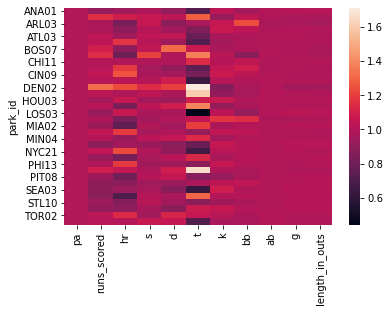

In [16]:
sns.heatmap(pfs)

# Now compute effects on scoring from component park factors

In [17]:
# Generate a league-average stat line (scaled to 1 PA)
event_freqs = home_game_totals[stats].sum()/home_game_totals['pa'].sum()
event_freqs

pa             1.000000
runs_scored    0.115676
hr             0.028315
s              0.149159
d              0.044923
t              0.004591
k              0.206491
bb             0.081876
ab             0.895919
dtype: float64

In [18]:
def compute_obp(stats):
    stats['ob'] = stats['hr'] + stats['s']+ stats['d']+ stats['t']+ stats['bb']
    obp = stats['ob']/stats['pa']
    return obp


In [19]:
def compute_ba(stats):
    stats['h'] = stats['hr'] + stats['s']+ stats['d']+ stats['t']
    ba = stats['h']/stats['ab']
    return ba


In [20]:
def compute_base_runs(stats):
    stats['tb'] =  stats['s'] + 2* stats['d'] + 3* stats['t'] + 4* stats['hr']
    stats['h'] =  stats['s'] +  stats['d'] +  stats['t'] +  stats['hr']
    a = stats['h'] + stats['bb'] - stats['hr']
    b = (1.4 * stats['tb'] - .6 * stats['h'] - 3 * stats['hr'] + .1 * stats['bb']) * 1.02
    c = stats['ab'] - stats['h']
    d = stats['hr'] 
    return (a*b)/(b+c)+d


In [21]:
def compute_woba(stats):
    woba_weights = {'ob': .702, 'tb': .37, 'h': -.21}
    stats['ob'] = stats['hr'] + stats['s']+ stats['d']+ stats['t']+ stats['bb']
    stats['tb'] =  stats['s'] + 2* stats['d'] + 3* stats['t'] + 4* stats['hr']
    stats['h'] =  stats['s'] +  stats['d'] +  stats['t'] +  stats['hr']

    woba = sum([stats[stat]*woba_weights[stat] for stat in woba_weights.keys()])/stats['pa']
    return woba
                

In [22]:
# compare total runs to total BaseRuns
home_game_totals['runs_scored'].sum(), compute_base_runs(home_game_totals[stats].sum())

(220908, 222043.88466339087)

In [23]:
# league-total obp
compute_obp(event_freqs)

0.30886428841101754

In [24]:
# league-total woba
compute_woba(home_game_totals[stats].sum())

0.30458939665992746

In [25]:
# league-total woba -- should be the same
compute_woba(event_freqs)

0.30458939665992746

In [26]:
# This is the relative difference in PA/outs between two OBPs
# Outs/PA is 1-OBP, so it follows from there.
# Can call this with obp1 as adjusted OBP and obp2 as league/baseline OBP
def compute_pa_adj(obp1, obp2):
    return ((1-obp2)/(1-obp1))

In [27]:
compute_pa_adj(.350, .3)

1.0769230769230769

In [28]:
# Take the league-average line and adjust it by component PFs
def compute_adj_freqs(pfs):
    events = ['s', 'd', 't', 'hr', 'bb', 'ab']
    return pfs[events] * event_freqs[events]


In [29]:
compute_adj_freqs(pfs)

,s,d,t,hr,bb,ab
park_id,,,,,,
ANA01,0.148685,0.040886,0.003306,0.026934,0.078151,0.899380
ARL02,0.158838,0.046563,0.005885,0.031015,0.085008,0.891854
ARL03,0.158097,0.040029,0.004458,0.023566,0.101512,0.869501
ATL02,0.150584,0.042960,0.003919,0.025440,0.084158,0.891275
ATL03,0.154685,0.046903,0.003618,0.026560,0.081331,0.894890
BAL12,0.151357,0.042340,0.003316,0.033223,0.081594,0.896932
BOS07,0.155250,0.059228,0.004908,0.025500,0.080575,0.897768
BUF05,0.179220,0.044574,0.006298,0.022592,0.072542,0.903610
CHI11,0.148969,0.044582,0.005243,0.027957,0.085128,0.890697


In [30]:
# Compute the park-adjusted league-average lines
adj_freqs = compute_adj_freqs(pfs)
adj_freqs['pa'] = 1

# Compute a few stats on these adjusted lines
pfs['woba'] = compute_woba(adj_freqs)
pfs['bsr'] = compute_base_runs(adj_freqs)
pfs['obp'] = compute_obp(adj_freqs)
pfs['ba'] = compute_ba(adj_freqs)

# Compute pfs by comparing the adjusted lines to unadjusted
pfs['pf_pa_exp'] = compute_pa_adj(pfs['obp'], compute_obp(event_freqs))
pfs['pf_woba'] = pfs['woba']/compute_woba(event_freqs)
pfs['pf_bsr'] = pfs['bsr']/compute_base_runs(event_freqs)
pfs['pf_ba'] = pfs['ba']/compute_ba(event_freqs)

pfs['papg'] = 1/pfs['g']
pfs['papo'] = 1/pfs['length_in_outs']

pfs

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,...,woba,bsr,obp,ba,pf_pa_exp,pf_woba,pf_bsr,pf_ba,papg,papo
park_id,,,,,,,,,,,,,,,,,,,,,
ANA01,1.0,0.925286,0.951231,0.996828,0.910132,0.720217,1.035261,0.954500,1.003863,1.004180,...,0.291812,0.107633,0.297963,0.244404,0.984472,0.958050,0.925716,0.964661,0.995837,0.985677
ARL02,1.0,1.154227,1.095340,1.064891,1.036509,1.281940,0.924853,1.038247,0.995462,0.976746,...,0.324549,0.130360,0.327309,0.271682,1.027419,1.065528,1.121182,1.072328,1.023807,1.027285
ARL03,1.0,0.971008,0.832293,1.059928,0.891043,0.971008,1.055019,1.239818,0.970512,0.971008,...,0.310471,0.118864,0.327662,0.260092,1.027959,1.019309,1.022303,1.026581,1.029858,1.038467
ATL02,1.0,0.985037,0.898464,1.009554,0.956297,0.853633,1.067193,1.027868,0.994816,0.999253,...,0.298255,0.111504,0.307061,0.250094,0.997397,0.979203,0.959010,0.987120,1.000748,1.001605
ATL03,1.0,1.038187,0.938022,1.037051,1.044070,0.788087,0.975630,0.993334,0.998851,1.004811,...,0.306390,0.117284,0.313097,0.258989,1.006162,1.005912,1.008717,1.022227,0.995212,1.007353
BAL12,1.0,1.035532,1.173341,1.014736,0.942487,0.722301,0.954936,0.996547,1.001130,0.993313,...,0.310739,0.121025,0.311829,0.256692,1.004308,1.020190,1.040892,1.013162,1.006732,1.003901
BOS07,1.0,1.091819,0.900581,1.040839,1.318416,1.069051,0.970533,0.984102,1.002064,0.988261,...,0.321506,0.127790,0.325460,0.272771,1.024603,1.055539,1.099074,1.076627,1.011878,1.021432
BUF05,1.0,1.151017,0.797868,1.201541,0.992223,1.371856,1.025028,0.885991,1.008585,0.990785,...,0.314967,0.122934,0.325225,0.279638,1.024247,1.034072,1.057314,1.103728,1.009301,1.020837
CHI11,1.0,1.005898,0.987353,0.998732,0.992396,1.142002,1.004027,1.039707,0.994171,1.001177,...,0.306626,0.117642,0.311878,0.254577,1.004380,1.006686,1.011800,1.004813,0.998825,1.002429


In [31]:
import plotly.express as px

In [32]:
# How does the composite BaseRuns-based pf do against runs/PA?
px.scatter(pfs.reset_index(), y='runs_scored', x='pf_bsr', trendline="ols", hover_name='park_id')

In [33]:
# How does the adjusted-OBP estimate of PA adjustment do against observed PA/out and PA/game?
px.scatter(pfs.reset_index(), y=['papo', 'papg'], x='pf_pa_exp', trendline="ols", hover_name='park_id')

In [34]:
pfs.sort_values(by='t')

,pa,runs_scored,hr,s,d,t,k,bb,ab,g,...,woba,bsr,obp,ba,pf_pa_exp,pf_woba,pf_bsr,pf_ba,papg,papo
park_id,,,,,,,,,,,,,,,,,,,,,
LOS03,1.0,0.922792,1.066119,0.980533,0.976921,0.440786,1.027379,0.918591,1.008133,1.026619,...,0.295709,0.110921,0.297563,0.246181,0.983912,0.970846,0.953993,0.971676,0.974071,0.981502
SEA03,1.0,0.887446,0.932800,0.967801,0.874222,0.625740,1.088044,0.999668,1.001789,1.018485,...,0.286964,0.104051,0.294763,0.237224,0.980005,0.942135,0.894901,0.936321,0.981850,0.979607
CLE08,1.0,1.016506,1.025175,1.002416,1.088443,0.647863,1.015108,0.989000,1.002778,0.999835,...,0.307979,0.118557,0.311393,0.256473,1.003673,1.011127,1.019663,1.012298,1.000165,1.002465
NYC21,1.0,1.044533,1.228029,0.999927,0.905890,0.657244,1.018615,1.016168,0.999971,1.010186,...,0.310513,0.120996,0.310833,0.254084,1.002856,1.019446,1.040644,1.002869,0.989917,1.006282
WAS11,1.0,1.015325,1.009322,1.057453,1.052773,0.708501,0.971332,0.968985,1.004762,0.996311,...,0.311491,0.120818,0.316191,0.263117,1.010715,1.022660,1.039115,1.038521,1.003702,1.005216
ANA01,1.0,0.925286,0.951231,0.996828,0.910132,0.720217,1.035261,0.954500,1.003863,1.004180,...,0.291812,0.107633,0.297963,0.244404,0.984472,0.958050,0.925716,0.964661,0.995837,0.985677
BAL12,1.0,1.035532,1.173341,1.014736,0.942487,0.722301,0.954936,0.996547,1.001130,0.993313,...,0.310739,0.121025,0.311829,0.256692,1.004308,1.020190,1.040892,1.013162,1.006732,1.003901
CHI12,1.0,1.015608,1.185222,0.965232,0.905466,0.750789,1.046303,1.092720,0.992614,0.999861,...,0.308726,0.119416,0.311124,0.249247,1.003280,1.013581,1.027052,0.983776,1.000139,1.004681
NYC20,1.0,0.890682,0.960202,0.929700,0.883485,0.785893,1.058243,1.016825,0.997469,1.017379,...,0.286272,0.104072,0.292412,0.234049,0.976749,0.939863,0.895087,0.923788,0.982918,0.981162


In [35]:
pfs.T

park_id,ANA01,ARL02,ARL03,ATL02,ATL03,BAL12,BOS07,BUF05,CHI11,CHI12,...,PHI13,PHO01,PIT08,SAN02,SEA03,SFO03,STL10,STP01,TOR02,WAS11
pa,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
runs_scored,0.925286,1.154227,0.971008,0.985037,1.038187,1.035532,1.091819,1.151017,1.005898,1.015608,...,0.994800,1.089712,0.947128,0.892617,0.887446,0.882290,0.946650,0.910749,1.031646,1.015325
hr,0.951231,1.095340,0.832293,0.898464,0.938022,1.173341,0.900581,0.797868,0.987353,1.185222,...,1.188055,1.044343,0.808296,0.889461,0.932800,0.701860,0.865896,0.902352,1.140279,1.009322
s,0.996828,1.064891,1.059928,1.009554,1.037051,1.014736,1.040839,1.201541,0.998732,0.965232,...,0.947437,0.996830,1.011193,0.950109,0.967801,1.010823,1.016855,0.968454,0.952265,1.057453
d,0.910132,1.036509,0.891043,0.956297,1.044070,0.942487,1.318416,0.992223,0.992396,0.905466,...,0.942560,1.096236,1.055670,0.928835,0.874222,0.978873,0.959095,0.886800,1.118166,1.052773
t,0.720217,1.281940,0.971008,0.853633,0.788087,0.722301,1.069051,1.371856,1.142002,0.750789,...,0.887955,1.667651,0.875143,0.972771,0.625740,1.298886,0.879498,1.080337,1.054720,0.708501
k,1.035261,0.924853,1.055019,1.067193,0.975630,0.954936,0.970533,1.025028,1.004027,1.046303,...,1.055392,0.993038,0.923344,1.035054,1.088044,1.008789,0.947226,1.058946,1.015053,0.971332
bb,0.954500,1.038247,1.239818,1.027868,0.993334,0.996547,0.984102,0.885991,1.039707,1.092720,...,1.009263,0.982032,0.975541,1.045167,0.999668,1.004499,0.976867,1.006663,0.975092,0.968985
ab,1.003863,0.995462,0.970512,0.994816,0.998851,1.001130,1.002064,1.008585,0.994171,0.992614,...,0.999996,1.001109,0.999045,0.998062,1.001789,0.999654,1.000062,0.999126,1.003074,1.004762
g,1.004180,0.976746,0.971008,0.999253,1.004811,0.993313,0.988261,0.990785,1.001177,0.999861,...,0.993664,0.990454,1.002380,1.005218,1.018485,1.007700,1.010100,1.013919,0.998707,0.996311
